# Multi-session analysis
This notebook demonstrate how to combine different xarray dataset together and perform group-level analysis

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions

## Build dataframe containing the metadata of all sessions

`build_session_info` will extract information from the by_sessions folder and build a dataframe for further filtering


In [49]:
def load_pycontrol_variables(session_path, parameters, criteria='tail'):
    session_id = session_path.name

    try:
        df_pycontrol = pd.read_pickle(session_path/'processed'/'df_pycontrol.pkl')
        # extract the parameter change, reshape them, and get the first/last value
        df_parameters = df_pycontrol[df_pycontrol.type=='parameters']
        df_parameters= df_parameters[df_parameters['name'].isin(parameters)]
        df_parameters = df_parameters.pivot(columns=['name'], values='value')
        df_parameters = df_parameters.fillna(method='ffill')
        df_parameters = df_parameters.dropna()
        df_parameters['session_id'] = session_id
        
        if not df_parameters.empty:
            if criteria=='tail':
                return df_parameters.tail(1)
            else:
                return df_parameters.head(1)
            print(df_parameters)
    except FileNotFoundError:
        pass
    
path = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-01-153226')
load_pycontrol_variables(path, ['hold_time_required_ms','water_duration_ms'], criteria='head')

name,hold_time_required_ms,water_duration_ms,session_id
16,600,25,TT002-2023-06-01-153226


In [52]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

df_session_info = build_session_info(root_path, load_pycontrol=True, pycontrol_parameters=['hold_time_required_ms', 'water_duration_ms'])
df_session_info

,animal_id,expt_datetime,session_id,task_name,path,session_no,water_duration_ms,hold_time_required_ms
0,RE602,2023-03-06 09:18:49,RE602-2023-03-06-091849,reaching_go_spout_feb23,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,1.0,25,NaN
1,kms060,2023-02-07 12:48:52,kms060-2023-02-07-124852,reaching_go_spout_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,11.0,20,NaN
2,kms061,2023-02-02 12:13:59,kms061-2023-02-02-121359,reaching_go_spout_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,7.0,20,NaN
3,kms063,2023-02-01 11:25:43,kms063-2023-02-01-112543,reaching_go_spout_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,6.0,18,NaN
4,RE604,2023-03-02 11:49:07,RE604-2023-03-02-114907,pavlovian_spontanous_reaching_march23,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,2.0,27,NaN
...,...,...,...,...,...,...,...,...
479,kms058,2023-02-21 11:52:13,kms058-2023-02-21-115213,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,3.0,20,100
480,kms058,2023-02-28 14:41:01,kms058-2023-02-28-144101,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,9.0,27,250
481,kms058,2023-02-22 16:21:47,kms058-2023-02-22-162147,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,4.0,21,400
482,RE607,2023-05-30 11:43:01,RE607-2023-05-30-114301,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,5.0,60,1000


## Loading data

`filter_sessions` provide a set of functions for filtering recording sessions. For details on how to use it, please consult its documentation

In [3]:
#select the last 5 sessions from animal kms058
df_sel = filter_sessions(df_session_info, 'kms058', session_no=5, session_method='tail', task_name='reaching_go_spout_bar_nov22')
df_sel

,animal_id,expt_datetime,session_id,task_name,path,session_no
246,kms058,2023-03-20 13:26:58,kms058-2023-03-20-132658,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,21.0
323,kms058,2023-03-22 18:26:17,kms058-2023-03-22-182617,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,22.0
334,kms058,2023-03-23 19:17:40,kms058-2023-03-23-191740,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,23.0
212,kms058,2023-03-24 15:12:54,kms058-2023-03-24-151254,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,24.0
240,kms058,2023-03-25 18:40:34,kms058-2023-03-25-184034,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,25.0


`load_and_conat_dataset` is a helper functions that combines multiple sessions of dataset together

In [4]:
paths = df_sel.path
ds_combined = load_and_concat_dataset(paths)

  0%|          | 0/5 [00:00<?, ?it/s]

Concating datasets...


In [5]:
ds_combined

<xarray.Dataset>
Dimensions:                            (trial_nb: 299, event_time: 120,
                                        session_id: 5)
Coordinates:
  * trial_nb                           (trial_nb) int64 1 2 3 4 ... 297 298 299
  * event_time                         (event_time) float64 -1.975e+03 ... 3....
  * session_id                         (session_id) object 'kms058-2023-03-20...
Data variables: (12/18)
    uid                                (session_id, trial_nb) object 'kms058_...
    trigger                            (session_id, trial_nb) object 'hold_fo...
    valid                              (session_id, trial_nb) float64 1.0 ......
    break_after_abort                  (session_id, trial_nb) float64 0.0 ......
    US_end_timer                       (session_id, trial_nb) float64 1.0 ......
    water_on                           (session_id, trial_nb) float64 1.0 ......
    ...                                 ...
    button_press                       (session_id, trial_nb) float64 0.0 ......
    waiting_for_spout                  (session_id, trial_nb) float64 1.0 ......
    success                            (session_id, trial_nb) float64 1.0 ......
    hold_for_water_analog_1_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_analog_1_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_analog_1_df_over_f     (session_id, trial_nb, event_time) float64 ...

## Plot figures

<Axes: xlabel='event_time', ylabel='hold_for_water_analog_1_df_over_f'>

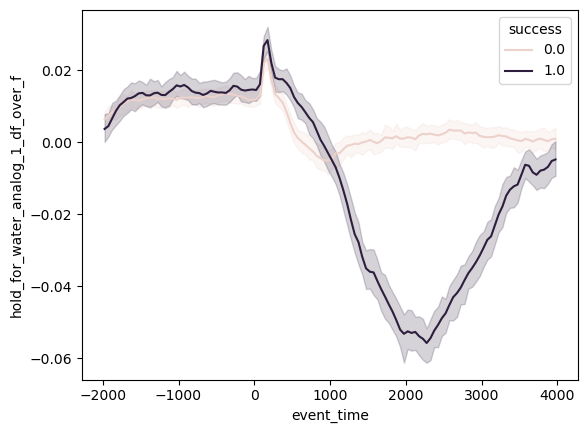

In [6]:
df2plot = ds_combined[['hold_for_water_analog_1_df_over_f', 'success']].to_dataframe().reset_index()
sns.lineplot(x='event_time',hue='success',
            y='hold_for_water_analog_1_df_over_f', n_boot=100, data=df2plot)

<Axes: xlabel='event_time', ylabel='first_bar_off_analog_1_df_over_f'>

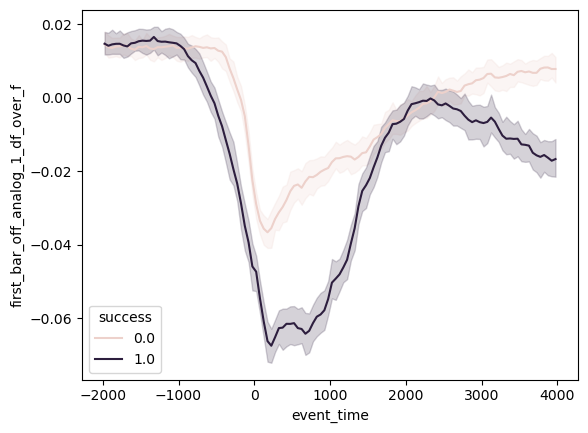

In [7]:
df2plot = ds_combined[['first_bar_off_analog_1_df_over_f', 'success']].to_dataframe().reset_index()
sns.lineplot(x='event_time',hue='success',
            y='first_bar_off_analog_1_df_over_f',n_boot=100,  data=df2plot)

<Axes: xlabel='event_time', ylabel='first_spout_analog_1_df_over_f'>

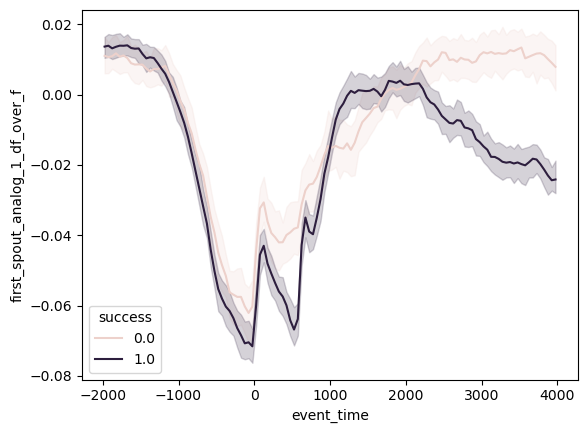

In [8]:
df2plot = ds_combined[['first_spout_analog_1_df_over_f', 'success']].to_dataframe().reset_index()
sns.lineplot(x='event_time',hue='success',
            y='first_spout_analog_1_df_over_f',n_boot=100,  data=df2plot)

### ACh

The following provides another examples on ACh data

In [9]:
df_sel = filter_sessions(df_session_info, 'RE602', session_no=3, session_method='tail', task_name='reaching_go_spout_bar_nov22')
df_sel


,animal_id,expt_datetime,session_id,task_name,path,session_no
302,RE602,2023-03-20 14:56:14,RE602-2023-03-20-145614,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,4.0
257,RE602,2023-03-21 14:36:10,RE602-2023-03-21-143610,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,5.0
318,RE602,2023-03-22 12:14:14,RE602-2023-03-22-121414,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,6.0


In [10]:
paths = df_sel.path
ds_ach_combined = load_and_concat_dataset(paths)

  0%|          | 0/3 [00:00<?, ?it/s]

Concating datasets...


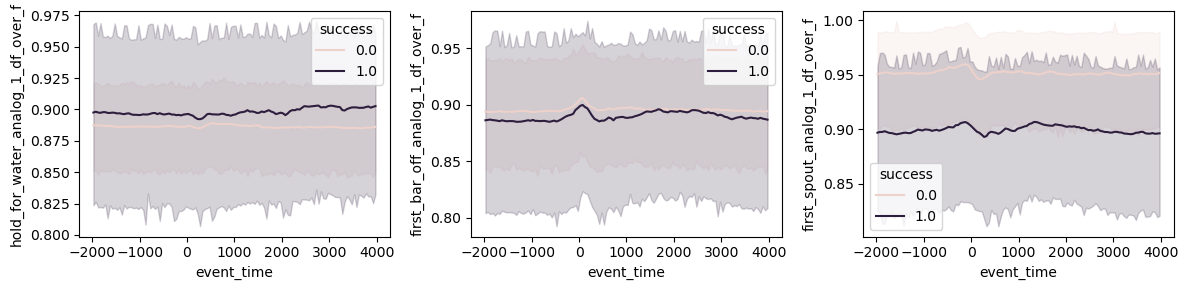

In [11]:
fig,ax = plt.subplots(1,3,figsize=(4*3,3))

df2plot = ds_ach_combined[['hold_for_water_analog_1_df_over_f', 'success']].to_dataframe().reset_index()
sns.lineplot(x='event_time',hue='success',
            y='hold_for_water_analog_1_df_over_f', data=df2plot, ax=ax[0])

df2plot = ds_ach_combined[['first_bar_off_analog_1_df_over_f', 'success']].to_dataframe().reset_index()
sns.lineplot(x='event_time',hue='success',
            y='first_bar_off_analog_1_df_over_f', data=df2plot, ax=ax[1])

df2plot = ds_ach_combined[['first_spout_analog_1_df_over_f', 'success']].to_dataframe().reset_index()
sns.lineplot(x='event_time',hue='success',
            y='first_spout_analog_1_df_over_f', data=df2plot, ax=ax[2])

fig.tight_layout()